In [9]:
import numpy as np
from scipy import stats
import random
from sklearn.utils import shuffle
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import regularizers

import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.display import Image

from config.utils import *
print("TF version: ", tf.__version__)

TF version:  2.12.0


In [10]:

noise_data = np.load('data/noise.npy')


def sample_from_noise_tf(data, shape):

    flat_noise = data.flatten()
    
    indices = np.random.choice(len(flat_noise), size=np.prod(shape), replace=True)
    
    sampled_noise = flat_noise[indices]
    
    return tf.convert_to_tensor(sampled_noise.reshape(shape), dtype=tf.float32)

# Example usage
sampled_noise_tf = sample_from_noise_tf(noise_data, [2, 2])
print(sampled_noise_tf)

tf.Tensor(
[[-1.2659446  0.3833223]
 [ 0.7778556 -0.8414418]], shape=(2, 2), dtype=float32)


In [11]:
station40 = pd.read_csv("data/station_40.csv")
station49 = pd.read_csv("data/station_49.csv")
station63 = pd.read_csv("data/station_63.csv")
station80 = pd.read_csv("data/station_80.csv")

stations = [station40,station49,station63,station80]

station40['ID'] = 'ST40'
station49['ID'] = 'ST49'
station63['ID'] = 'ST63'
station80['ID'] = 'ST80'

stations = pd.concat([station40, station49, station63, station80], ignore_index=True)

In [12]:
stations['T_SUM'] = stations['W_1']+stations['W_2']+stations['W_3']+stations['W_4']+stations['W_5']+stations['W_6']+stations['W_7']+stations['W_8']+stations['W_9']
stations['R_SUM'] = stations['W_13']+stations['W_14']+stations['W_15']

stations_summed = stations.groupby(['YEAR']).agg(
    T_BAR=('T_SUM', lambda x: x.sum() / 36),
    R_BAR=('R_SUM', lambda x: x.sum() / 12)
).reset_index()

stations_summed['T_cat'] = pd.cut(stations_summed['T_BAR'], bins=[-float('inf'), 21.2, 22, float('inf')], labels=[1, 2, 3])

stations_summed['R_cat'] = pd.cut(stations_summed['R_BAR'], bins=[-float('inf'), 1.8, 2.2, float('inf')], labels=[1, 2, 3])


In [13]:

stations_summed['T_cat'] = stations_summed['T_cat'].astype(str)
stations_summed['R_cat'] = stations_summed['R_cat'].astype(str)

scenario_mapping = {
    '1,1': '1', '1,2': '2', '1,3': '3',
    '2,1': '4', '2,2': '5', '2,3': '6',
    '3,1': '7', '3,2': '8', '3,3': '9'
}

stations_summed['scenario'] = stations_summed.apply(lambda row: scenario_mapping[row['R_cat'] + ',' + row['T_cat']], axis=1)

stations_count_check = stations_summed.groupby('scenario').size().reset_index(name='n_scenario')


In [14]:
station40['scenario'] = stations_summed['scenario']
station49['scenario'] = stations_summed['scenario']
station63['scenario'] = stations_summed['scenario']
station80['scenario'] = stations_summed['scenario']

stations = pd.concat([station40, station49, station63, station80], ignore_index=True)

In [15]:

subsets = {}

sceanrios = ['1','2','3','4','5','6','7','8','9']

for scenario in sceanrios:

    subset = stations[stations['scenario'] == scenario]

    pivot_subset = subset.pivot_table(index='YEAR', columns='ID', values='YIELD', aggfunc='first').reset_index()

    subsets[scenario] = pivot_subset


In [16]:
DATA_DIM = 4  # This represents the maize yield for 4 stations


def build_generator(latent_dim, n_neurons, data_dim=DATA_DIM):
    model = tf.keras.Sequential(name="Enhanced_Generator")
    
    # Input and first dense layer with initialization and PReLU activation
    model.add(layers.Dense(n_neurons, input_shape=(latent_dim,),
                           kernel_initializer="he_normal", bias_initializer="he_normal"))
    model.add(layers.PReLU(alpha_initializer='zeros'))
    model.add(layers.BatchNormalization())  # Helps in stabilizing learning
    
    # Second dense layer with PReLU and dropout for regularization
    model.add(layers.Dense(n_neurons, kernel_initializer="he_normal", bias_initializer="he_normal"))
    model.add(layers.PReLU(alpha_initializer='zeros'))
    model.add(layers.BatchNormalization())  # Helps in stabilizing learning
    model.add(layers.Dropout(0.2))  # Dropout for regularization
    
    # Output layer that matches the dimensionality of the crop yield data
    model.add(layers.Dense(data_dim, kernel_initializer="he_normal", bias_initializer="he_normal"))
    
    return model


G_test = build_generator(latent_dim=1, n_neurons=50)
G_test.summary()

def build_discriminator(n_neurons, data_dim=DATA_DIM):
    model = tf.keras.Sequential(name="Advanced_Discriminator")
    
    # Input layer and first dense layer with initialization, LeakyReLU activation, and kernel regularization
    model.add(layers.Dense(n_neurons, input_shape=(data_dim,),
                           kernel_initializer="he_normal", bias_initializer="he_normal",
                           kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Second dense layer with LeakyReLU, dropout, and kernel regularization
    model.add(layers.Dense(n_neurons, kernel_initializer="he_normal", bias_initializer="he_normal",
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Introduce a BatchNormalization layer to improve training stability
    model.add(layers.BatchNormalization())
    
    # Third dense layer with LeakyReLU, dropout, and kernel regularization
    model.add(layers.Dense(n_neurons, kernel_initializer="he_normal", bias_initializer="he_normal",
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Fourth dense layer, maintaining structure but focusing on regularization, non-linearity, and BatchNormalization
    model.add(layers.Dense(n_neurons, kernel_initializer="he_normal", bias_initializer="he_normal",
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    # Output layer with a single neuron for binary classification (real vs. generated)
    # Using sigmoid activation for binary classification
    model.add(layers.Dense(1, kernel_initializer="he_normal", bias_initializer="he_normal", activation='sigmoid'))
    
    return model



D_test = build_discriminator(n_neurons=500)
D_test.summary()

Model: "Enhanced_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 p_re_lu (PReLU)             (None, 50)                50        
                                                                 
 batch_normalization (BatchN  (None, 50)               200       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 p_re_lu_1 (PReLU)           (None, 50)                50        
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                

In [17]:
def discriminator_loss(real_output, fake_output): 
 
    return -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(real_output)) + tf.math.log(1-tf.nn.sigmoid(fake_output)))
  

def generator_loss(fake_output, generated_data):
    # Standard GAN generator loss (for example, using Wasserstein loss)
    standard_loss = -tf.reduce_mean(fake_output)

    # Penalize negative values in generated data
    #penalty_for_negatives = tf.reduce_mean(tf.square(tf.minimum(generated_data, 0)))

    # Combine the losses
    return standard_loss #+ penalty_for_negatives


In [18]:


# Training parameters:
# -------------------
EPOCHS =  80 # one forward/backward pass in all training samples
BATCH_SIZE = 32  # Number of training sample in one forward/backward pass
LATENT_DIM = 32
NEURONS_G = 800
NEURONS_D = 900
# -------------------

# Neural networks in the GAN
generator = build_generator(LATENT_DIM, NEURONS_G)
discriminator = build_discriminator(NEURONS_D)

# Optimizers
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00002)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)


list_loss_G_train=[]
list_loss_D_train=[]

# ===========================================================================
# ===========================================================================



@tf.function
def train_step(data_batch, noise_dim):
    batch_size = data_batch.shape[0]

    # Discriminator training
    noise = sample_from_noise_tf(noise_data, [batch_size, noise_dim])
    
    num_disc_updates = 5  # Number of times to update the discriminator per generator update

    for _ in range(num_disc_updates):
        with tf.GradientTape(persistent=True) as disc_tape:
            # Generate fake data
            noise = tf.random.normal([batch_size, noise_dim])
            #noise = sample_from_noise_tf(noise_data, [batch_size, noise_dim])
            generated_data = generator(noise, training=True)  # G(z)

            # Discriminator output for real and fake data
            real_output = discriminator(data_batch, training=True)  # D(x)
            fake_output = discriminator(generated_data, training=True)  # D(G(z))

            # Compute discriminator loss
            disc_loss = discriminator_loss(real_output, fake_output)

        # Compute gradients of discriminator
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Apply gradients to update the discriminator
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Clean up the persistent gradient tape
    del disc_tape
    
        
    # Generator training
    noise = tf.random.normal([batch_size, noise_dim]) # z = (z_1, .., z_m)

    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise, training=True)  # G(z) 
        fake_output = discriminator(generated_data, training=True)  # D(G(z))

        gen_loss = generator_loss(fake_output, generated_data)  # Updated generator loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return

def evaluate(data_batches, noise_dim):
    total_loss_G = 0
    total_loss_D = 0
    num_batches = 0

    for data_batch in data_batches:
        batch_size = data_batch.shape[0]

        noise = sample_from_noise_tf(noise_data, [batch_size, noise_dim])

        generated_data = generator(noise)
        real_output = discriminator(data_batch)
        fake_output = discriminator(generated_data)

        loss_D = discriminator_loss(real_output, fake_output)
        loss_G = generator_loss(fake_output, generated_data)

        total_loss_G += loss_G.numpy()
        total_loss_D += loss_D.numpy()
        num_batches += 1

    avg_loss_G = total_loss_G / num_batches
    avg_loss_D = total_loss_D / num_batches

    return avg_loss_G, avg_loss_D

In [19]:
# Load datasets

inspect_df = subsets['1']

data = inspect_df
data = data.set_index('YEAR')
print(data)

# Convert to TensorFlow dataset
dataset_train = tf.data.Dataset.from_tensor_slices(data.values.astype('float32'))
data_batches = dataset_train.shuffle(len(data)).batch(BATCH_SIZE)

ID     ST40  ST49  ST63  ST80
YEAR                         
19    14.15  4.14  0.00  3.97
34    11.08  3.74  0.00  4.13
60     7.63  4.52  0.58  5.91
63    10.14  6.75  0.58  4.97
83     7.92  7.17  0.00  4.64
...     ...   ...   ...   ...
9901   9.27  4.41  0.84  7.53
9911   8.22  5.40  0.71  4.13
9982   9.22  6.34  0.76  4.93
9986  12.24  4.51  0.34  5.90
9987   9.37  4.32  0.08  4.78

[464 rows x 4 columns]


In [20]:
from sklearn.preprocessing import StandardScaler
import pandas as pd


data = inspect_df
data = data.set_index('YEAR')

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data and transform it
scaled_data = scaler.fit_transform(data)

# Convert the scaled data back to a DataFrame (optional, for verification)
scaled_data_df = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)


# Convert to TensorFlow dataset
dataset_train = tf.data.Dataset.from_tensor_slices(scaled_data.astype('float32'))
data_batches = dataset_train.shuffle(len(scaled_data)).batch(BATCH_SIZE)


In [21]:
def generate_plots():
    num_samples = 1000
    noise = sample_from_noise_tf(noise_data, [num_samples, LATENT_DIM])
    generated_data = generator(noise, training=False).numpy()

    # Visualization
    for i in range(4):  # Assuming 4 weather stations
        plt.subplot(2, 2, i+1)
        plt.hist(generated_data[:, i], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Station {i+1} Yield Distribution')
    plt.tight_layout()
    plt.show()

Epoch 80 (2.32 sec): Loss Generator=-0.225, Loss Discriminator=1.369
Generated vector Y_tilde at epoch 80: [[-2.3596551  -2.0493002   0.64762753 -1.3957939 ]]


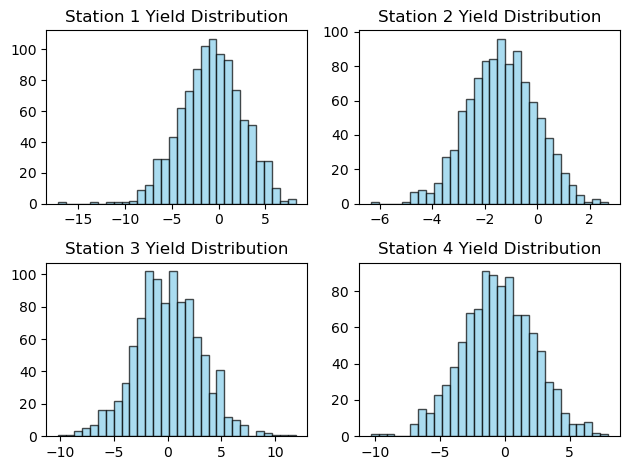

End of training.


In [22]:
import matplotlib.pyplot as plt

# Training loop:
print("Start of training ...")

generate_every_n_epochs = 10

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    
    for data_batch in data_batches:
        train_step(data_batch, LATENT_DIM)
    
    if (epoch) % generate_every_n_epochs == 0:    
        loss_G, loss_D = evaluate(data_batches, LATENT_DIM)  
        list_loss_G_train.append(loss_G)
        list_loss_D_train.append(loss_D)
        
        time_epoch = time.time() - start_time
        display.clear_output(wait=True)
        print("Epoch {} ({:.2f} sec): Loss Generator={:.3f}, Loss Discriminator={:.3f}".format(
            epoch, time_epoch, loss_G, loss_D))
        
        # Generate a single sample of Y_tilde from the current state of the generator
        noise = tf.random.normal([1, LATENT_DIM])
        Y_tilde = generator(noise, training=False)
        print("Generated vector Y_tilde at epoch {}: {}".format(epoch, Y_tilde.numpy()))
        generate_plots()
        
print("End of training.")


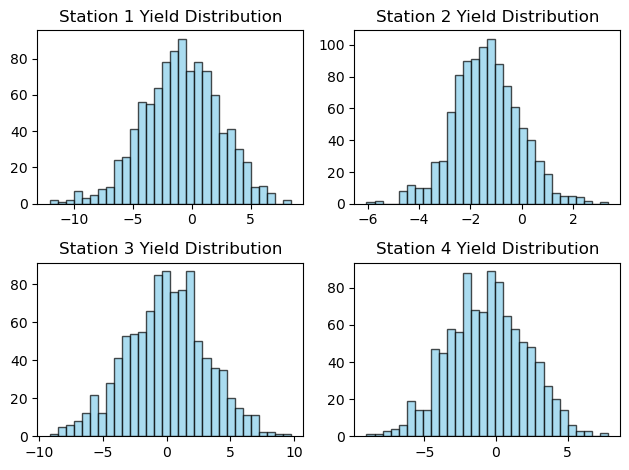

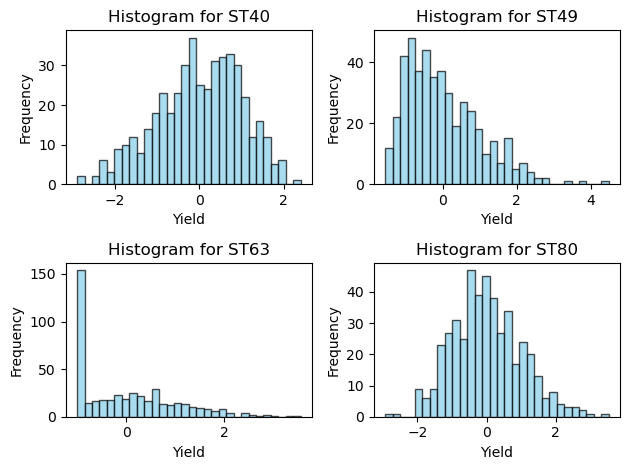

In [23]:
# Generate 1000 samples from the generator

num_samples = 1000
noise = sample_from_noise_tf(noise_data, [num_samples, LATENT_DIM])
generated_data = generator(noise, training=False).numpy()

# Visualization
for i in range(4):  # Assuming 4 weather stations
    plt.subplot(2, 2, i+1)
    plt.hist(generated_data[:, i], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Station {i+1} Yield Distribution')
plt.tight_layout()
plt.show()

stations = ['ST40', 'ST49', 'ST63', 'ST80']
for i, station in enumerate(stations, 1):
    plt.subplot(2, 2, i)
    plt.hist(scaled_data_df[station], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Histogram for {station}')
    plt.xlabel('Yield')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [24]:
generator.save('parameters/generator_scen_1.h5')